In [1]:
from scipy.stats import entropy
import pandas
import numpy
from tqdm import tqdm
import sys
import seaborn
import matplotlib
pandas.set_option('display.max_columns', None)
from tqdm.notebook import trange, tqdm
from time import sleep
import numpy
from joblib import Parallel, delayed


In [2]:
import subprocess
import os.path

In [3]:
OUTPUT_IMAGE_PATH = "./../report/fragments/04_experimental_execution/images/"

In [4]:
def instanciate_runner(executable_path, input_path="./", output_path="/tmp"):

    if os.path.exists(executable_path):
        def execute_experiment( input_file:str, input_size:int, extractions:int, output_file:str = None, generate_dataframe=False, enable_reuse=0,
                                log_pivot_time = 0, log_iteration_time = 0, log_extraction_time = 0, log_swaps = 0, use_random_pivot = 0,
                                use_bfprt = 0, use_iiqs = 0, set_bfprt_alpha = 0.3, set_bfprt_beta = 0.7, set_random_seed = 42, 
                                set_pivot_bias = 0.5, set_redundant_bias = 0.5, thread_id="" ):
            if output_file == None:
                output_file = input_file.split("/")[-1]
            arguments = [
            ('--log-iteration-time=' + str(log_iteration_time)),
            ('--log-pivot-time=' + str(log_iteration_time)),
            ('--log-swaps=' + str(log_iteration_time)),
            ('--log-extraction-time=' + str(log_extraction_time)),
            ('--enable-reuse=' + str(enable_reuse)),
            ('--use-bfprt=' + str(use_bfprt)),
            ('--use-iiqs=' + str(use_iiqs)),
            ('--set-bfprt-alpha=' + str(set_bfprt_alpha)),
            ('--set-bfprt-beta=' + str(set_bfprt_beta)),
            ('--use-random-pivot=' + str(use_random_pivot)),
            ('--set-random-seed=' + str(set_random_seed)),
            ('--set-pivot-bias=' + str(set_pivot_bias)),
            ('--set-redundant-bias=' + str(set_redundant_bias)),
            ('--input-file=' + '/'.join([input_path, str(input_file)])),
            ('--output-file=' + '/'.join([output_path, str(output_file + thread_id)])),
            ('--input-size=' + str(input_size)),
            ('--extractions=' + str(extractions))]
            # print(" ".join([''+executable_path] + arguments))
            result = subprocess.run(" ".join([''+executable_path] + arguments), shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # print(result.stdout.decode('utf-8'))
            # print(result.stderr.decode('utf-8'))
            return pandas.read_csv('/'.join([output_path, str(output_file + thread_id)]))
        return execute_experiment
    else:
        return None

In [5]:
#runner = instanciate_runner('/home/kuky_nekoi/magicode/program/base_benchmark/main')
runner = instanciate_runner('/home/kuky_nekoi/Documents/Sources/KuKy_NeKoi/magicode/program/base_benchmark/main_prototype',
                            input_path='/home/kuky_nekoi/Documents/Sources/KuKy_NeKoi/magicode/experiments/01_base_benchmark_data')

In [ ]:
N = 10**4
pivot_bias = 0.0

result_iiqs = runner('random/N_6.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0,
                    set_pivot_bias=pivot_bias, use_iiqs=1, use_bfprt=1)

result_iqs = runner('random/N_6.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0,
                    set_pivot_bias=pivot_bias, use_iiqs=0)

result_iiqs_d = runner('sorted_decreasing/N_6.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0,
                    set_pivot_bias=pivot_bias, use_iiqs=1, use_bfprt=1)
result_iqs_d = runner('sorted_decreasing/N_6.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0,
                    set_pivot_bias=pivot_bias, use_iiqs=0)

result_iiqs_i = runner('sorted_increasing/N_6.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0,
                    set_pivot_bias=pivot_bias, use_iiqs=1, use_bfprt=1)
result_iqs_i = runner('sorted_increasing/N_6.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_redundant_bias=0,
                    set_pivot_bias=pivot_bias, use_iiqs=0)

result_df = pandas.concat([result_iqs, result_iiqs,result_iqs_d, result_iiqs_d,result_iqs_i, result_iiqs_i])

result_df["param.use_iiqs"] = result_df["param.use_iiqs"].apply(lambda x: "IIQS" if x == 1 else "IQS" )
result_df["param.set"] = result_df["input_file_value"].apply(lambda x: x.split("/")[-2] )
result_df["hue"] = result_df["param.use_iiqs"] + " " + result_df["param.set"]

In [ ]:
plot_df = result_df[  result_df["snapshot.snapshot_point"] == "EXTRACTION_STAGE_END"]

plot_df_sorted_inc = plot_df[plot_df["param.set"] == "sorted_increasing"]
plot_df_sorted_dec = plot_df[plot_df["param.set"] == "sorted_decreasing"]
plot_df_random = plot_df[plot_df["param.set"] == "random"]

In [ ]:
def plot_base_benchmark(dataframe, output_file, size=(16, 24), prepend="" ):
    
    fig, axes = matplotlib.pyplot.subplots(nrows=3, ncols=2, figsize=size)

    seaborn.lineplot(x="snapshot.current_extraction", y="snapshot.total_extraction_time", 
                    data=dataframe, ax=axes[0,0], hue="param.use_iiqs").set_title(prepend + "Cumulated extraction time")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.extraction_time", 
                    data=dataframe, linewidth=0, alpha=0.5, ax=axes[1,0], hue="param.use_iiqs").set_title(prepend + "Extraction time distribution")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.current_stack_size", 
                    data=dataframe, linewidth=0, alpha=0.5, ax=axes[2,0], hue="param.use_iiqs").set_title(prepend + "Stack size per extraction")

    plot_df_head = dataframe[ (dataframe["snapshot.current_extraction"] < 1000)]
    
    #fix for logplot
    #plot_df_head["snapshot.extraction_time"] = plot_df_head["snapshot.extraction_time"].apply(lambda x: x+0.1)
    #plot_df_head["snapshot.current_stack_size"] = plot_df_head["snapshot.current_stack_size"].apply(lambda x: x+0.1)
    #display(plot_df_head["snapshot.current_stack_size"].describe())
    
    axes[0,1].set(yscale="symlog")
    axes[1,1].set(yscale="symlog")
    axes[2,1].set(yscale="symlog")

    seaborn.lineplot(x="snapshot.current_extraction", y="snapshot.total_extraction_time", 
                    data=plot_df_head, ax=axes[0,1], hue="param.use_iiqs").set_title(prepend + "Cumulated extraction time")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.extraction_time", 
                    data=plot_df_head, linewidth=0, alpha=0.5, ax=axes[1,1], hue="param.use_iiqs").set_title(prepend + "Extraction time distribution")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.current_stack_size", 
                    data=plot_df_head, linewidth=0, alpha=0.5, ax=axes[2,1], hue="param.use_iiqs").set_title(prepend + "Stack size per extraction")

    fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')
                             

In [ ]:
plot_df_random["snapshot.current_stack_size"].describe()

In [ ]:
                         
plot_base_benchmark(plot_df_random, "01_basebenchmark_01_random_case.png", prepend="RANDOM - ")
    

In [ ]:
                         
plot_base_benchmark(plot_df_sorted_inc, "01_basebenchmark_02_sort_a_case.png", prepend="ASC - ")
    
                         

In [ ]:
plot_base_benchmark(plot_df_sorted_dec, "01_basebenchmark_03_sort_d_case.png", prepend="DESC - ")
    

In [ ]:
N = 10**4
pivot_bias = 0.0
redundant_bias = 1.0

result_iiqs = runner('bins/N_4_R_0_C_1.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias, use_iiqs=1, use_bfprt=1, set_redundant_bias=redundant_bias)

result_iqs = runner('bins/N_4_R_0_C_1.fold_1.ascii', N, N, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias, use_iiqs=0, set_redundant_bias=redundant_bias)

result_df = pandas.concat([result_iqs, result_iiqs])

result_df["param.use_iiqs"] = result_df["param.use_iiqs"].apply(lambda x: "IIQS" if x == 1 else "IQS" )
result_df["param.set"] = result_df["input_file_value"].apply(lambda x: x.split("/")[-2] )
result_df["hue"] = result_df["param.use_iiqs"] + " " + result_df["param.set"]

plot_df_one_class = result_df[result_df["snapshot.snapshot_point"] == "EXTRACTION_STAGE_END"]

plot_base_benchmark(plot_df_one_class, "01_basebenchmark_04_single_class.png", prepend="SINGLE_CLASS - ")

In [6]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def log_column(column):
    def _lambda(df):
        df["log("+column+")"] = numpy.log10(df[column])
        return df
    return _lambda

In [10]:
def parallel_iiqs(alpha, beta, filename):
    result_iiqs = runner(filename, n, extractions, 
                        generate_dataframe=True,
                        log_extraction_time=1,
                        set_pivot_bias=pivot_bias, use_iiqs=1, 
                        use_bfprt=1, set_redundant_bias=redundant_bias,
                        set_bfprt_alpha=alpha, set_bfprt_beta=beta, 
                        thread_id= "_iiqs_"+str(alpha)+"_"+str(beta))
    result_iiqs["experiment.classes"] = 0
    result_iiqs["experiment.noise"] = n
    return result_iiqs

def parallel_iqs(alpha, beta, filename):
    result_iqs = runner(filename, n, extractions, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias, use_iiqs=0, set_redundant_bias=redundant_bias,
                    set_bfprt_alpha=alpha, set_bfprt_beta=beta, 
                    thread_id= "_iqs_"+str(alpha)+"_"+str(beta))
    result_iqs["experiment.classes"] = 0
    result_iqs["experiment.noise"] = n
    return result_iqs

In [11]:


def plot_3d_scatter(x,y,z, data, fig, bounds=(1,1,1,), preprocess=None, filters=[], title="",
                    logcolor=True, log_x=False, log_y=False, log_z=False,
                    invert_x=False, invert_y=False, invert_z=False,
                    projection="3d", proj_type = 'persp',
                    view_angle = None, s=100, alpha=1):
    #ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax = fig.add_subplot(bounds[0],bounds[1],bounds[2], projection=projection, proj_type = proj_type)
    
    sample = data
    
    if preprocess:
        sample = preprocess(sample)
    
    for custom_filter in filters:
        if custom_filter[1] == "eq":
            sample = sample[(sample[custom_filter[0]] == custom_filter[2])]  
        elif custom_filter[1] == "leq":
            sample = sample[(sample[custom_filter[0]] <= custom_filter[2])]  
        elif custom_filter[1] == "geq":
            sample = sample[(sample[custom_filter[0]] >= custom_filter[2])]  
        elif custom_filter[1] == "le":
            sample = sample[(sample[custom_filter[0]] < custom_filter[2])]  
        elif custom_filter[1] == "gt":
            sample = sample[(sample[custom_filter[0]] > custom_filter[2])]
    
    _x = sample[x]
    _y = sample[y]
    _z = sample[z]
    _c = _z
    
    if logcolor:
       _c = numpy.log10(_z)
    
    if log_x:
        ax.xaxis.set_scale('log')
    if log_y:
        ax.yaxis.set_scale('log')
    if log_z:
        ax.zaxis.set_scale('log')
        
    if invert_x:
        ax.invert_xaxis()
    if invert_y:
        ax.invert_yaxis()
    if invert_z:
        ax.invert_zaxis()
    
    ax.scatter(_x, _y, _z, c=_c, cmap='rainbow',s=s, alpha=alpha)
    ax.set_xlim(min(_x), max(_x))
    ax.set_ylim(min(_y), max(_y))
    ax.set_zlim(min(_z), max(_z))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(title)
    
    if view_angle:
        ax.view_init(view_angle[0], view_angle[1])

In [12]:
def plot_base_benchmark_3d(x,y,z, data, filters, title, file, s=100, alpha=1):
    fig = plt.figure(figsize=(16,24))

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,1,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,2,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 1)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,3,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,4,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,5,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,6,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    fig.savefig(OUTPUT_IMAGE_PATH + file, bbox_inches='tight')

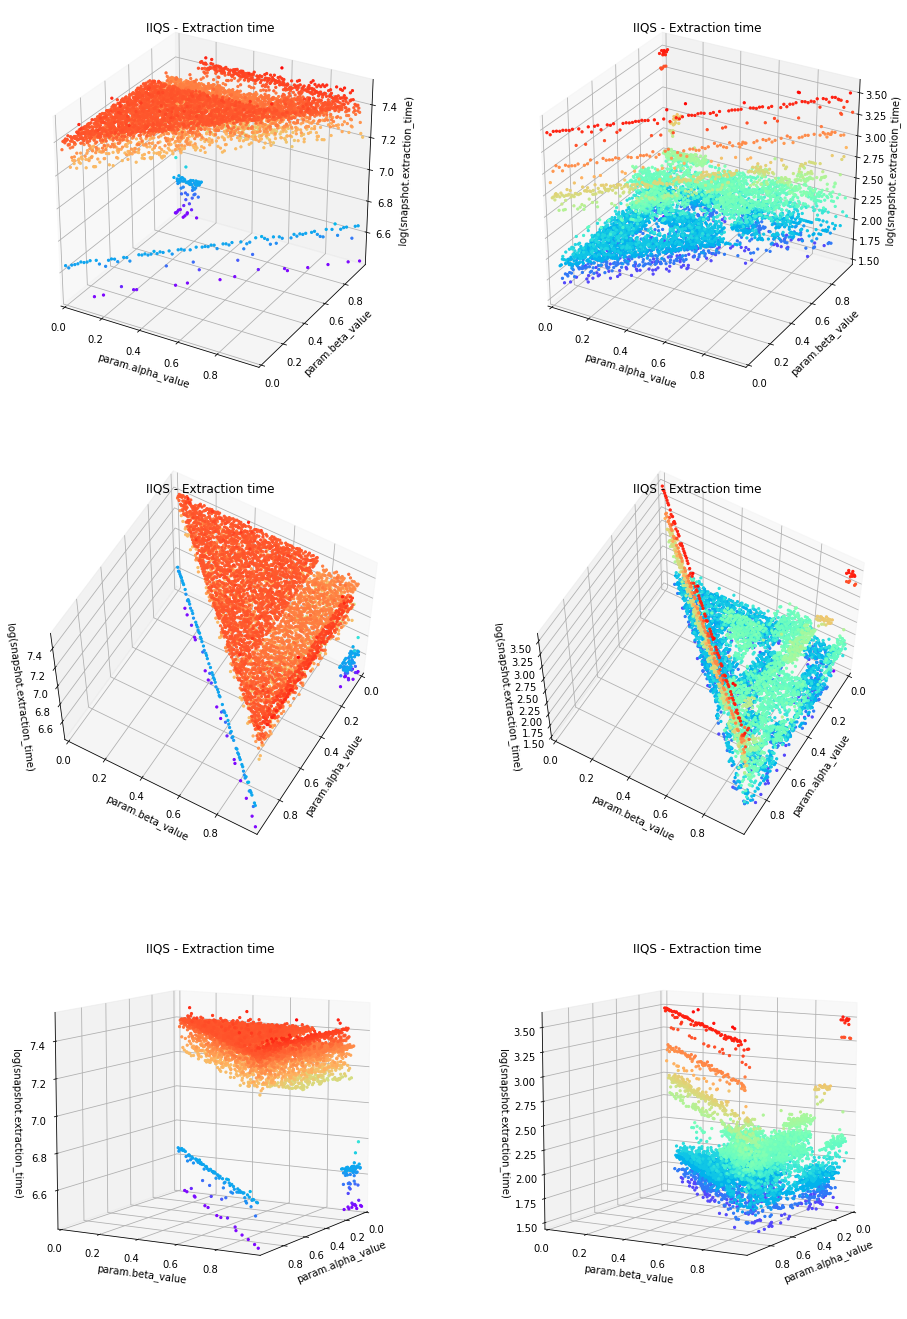

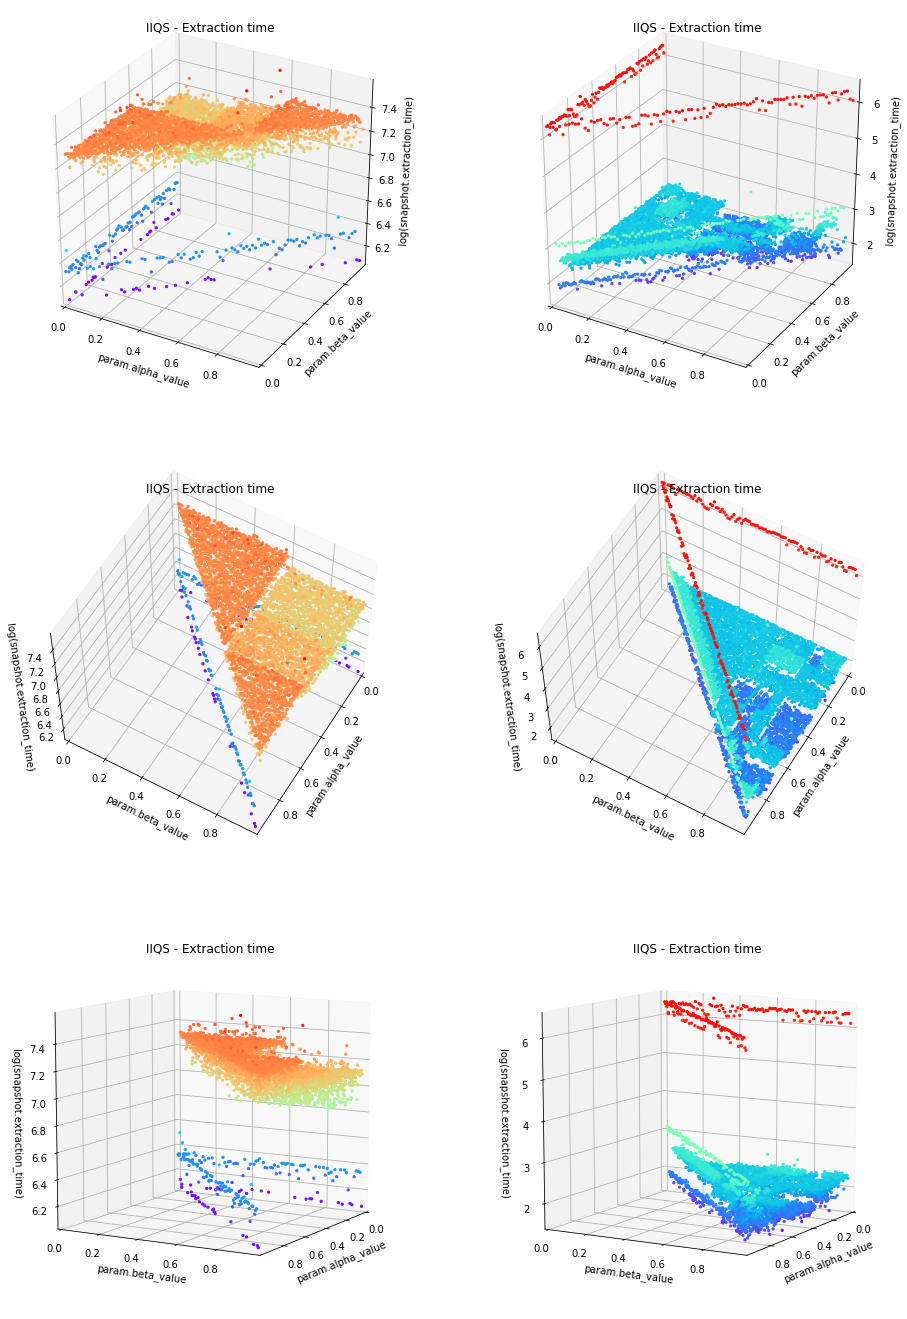

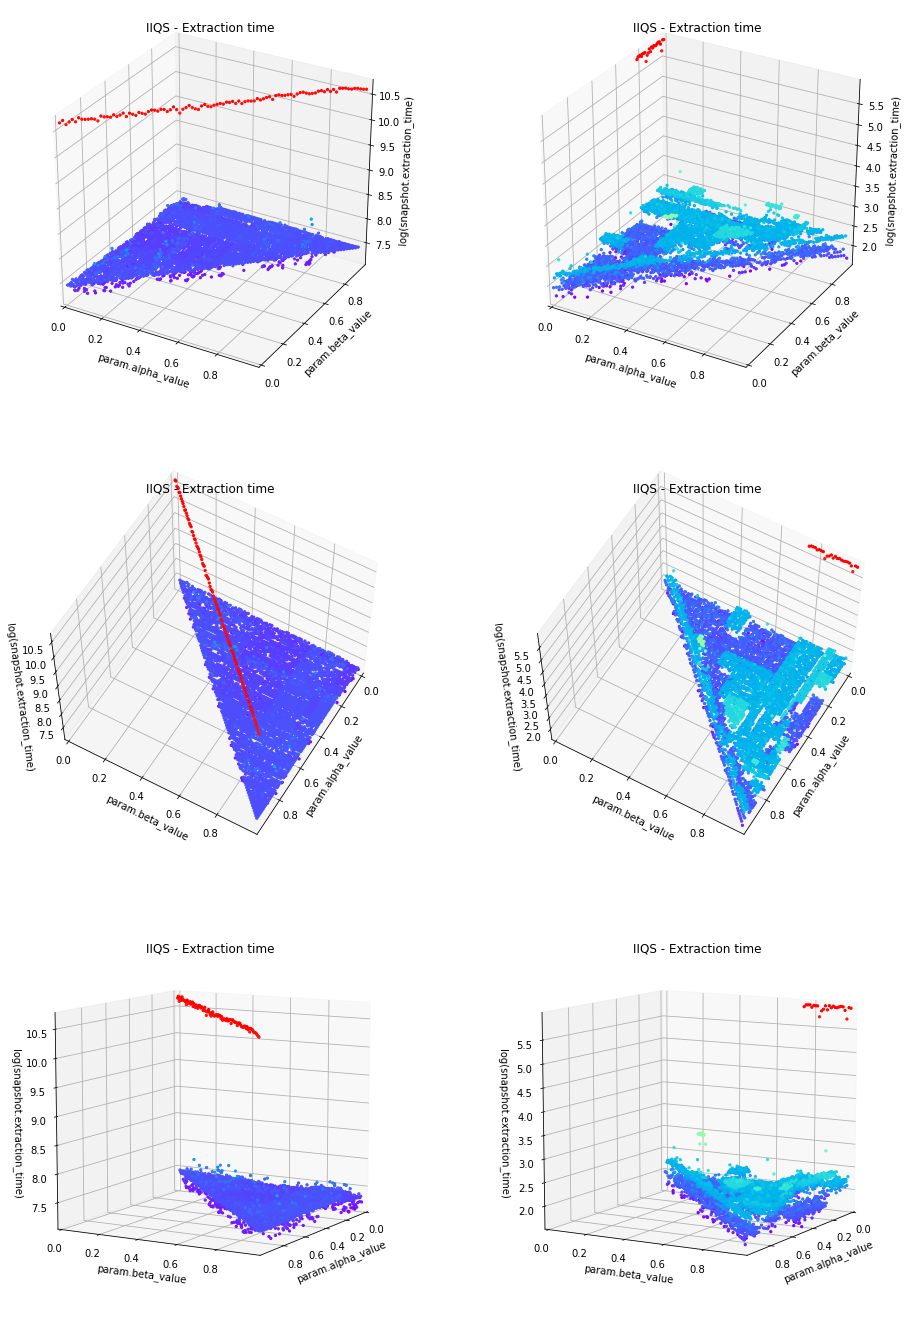

In [28]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 6
n = 10**N
extractions=10
pivot_bias = 0.0
redundant_bias = 0.5
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = list(numpy.arange(0,1,0.01))
beta_values = list(numpy.arange(0,1,0.01))
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha <= beta):
            combinations.append((alpha, beta,))
R = 0

In [ ]:
filename = 'random/N_6.fold_1.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename) for c in combinations )
iqs_results = Parallel(n_jobs=10)( delayed(parallel_iqs)(c[0], c[1], filename) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
dataframes.extend(iqs_results)
        
result_df_alphabeta = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta = result_df_alphabeta.sort_values(["snapshot.extraction_time"])
result_df_alphabeta["param.alpha_value"] = result_df_alphabeta["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta, filters=[], 
                       title="Extraction time", file="04_alphabeta_singleclass.png", s=5)

In [ ]:
filename = 'sorted_increasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        

result_df_alphabeta_asc = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta_asc = result_df_alphabeta_asc.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_asc["param.alpha_value"] = result_df_alphabeta_asc["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta_asc, filters=[], 
                       title="Extraction time", file="04_alphabeta_singleclass_asc.png", s=5)

In [27]:
filename = 'sorted_decreasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        
result_df_alphabeta_desc = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta_desc = result_df_alphabeta_desc.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_desc["param.alpha_value"] = result_df_alphabeta_desc["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta_desc, filters=[], 
                       title="Extraction time", file="04_alphabeta_singleclass_desc.png", s=5)